In [1]:
import os
import cv2 
import random 
import numpy as np
from matplotlib import pyplot as plt 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D, Dense,MaxPooling2D,Input,Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
POS_PATH = os.path.join('D:\data', 'positive')
NEG_PATH = os.path.join('D:\data', 'negative')
ANC_PATH = os.path.join('D:\data', 'anchor')

In [6]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [88]:
#!tar -xf lfw.tgz 

In [89]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        CUR_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(CUR_PATH, NEW_PATH)

In [5]:
# generate random unique image names 
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'D:\\data\\anchor\\82e18cfe-2c77-11ef-88d1-cfd74ba3208b.jpg'

In [7]:
#Camera Availability
cam_avail = []

for camera in range(10):
    cap = cv2.VideoCapture(camera)
    if cap.isOpened():
        print("Camera available:",camera)
        cam_avail.append(camera)
        cap.release()
print(cam_avail)

Camera available: 0
[0]


In [8]:
#Establishing Connection to Webcam 
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    #cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250]
    #collecting anchor 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #save the anchor image
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collected", frame)

    k = cv2.waitKey(30) & 0xff
    if k == 113: 
        break

cap.release() 

# De-allocate any associated memory usage 
cv2.destroyAllWindows() 


KeyboardInterrupt: 

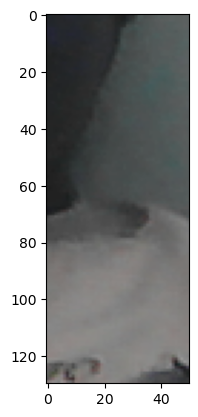

In [9]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [10]:
import time 
number_images = 6 

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    imgname = os.path.join(POS_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('6 images',frame)
    time.sleep(5)

    k = cv2.waitKey(30) & 0xff
    if k == 113: 
        break

cap.release() 

# De-allocate any associated memory usage 
cv2.destroyAllWindows() 


In [6]:
# Create a Datase of each type of image
anchor= tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(6)
positive= tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(6)
negative= tf.data.Dataset.list_files(NEG_PATH+ '/*.jpg').take(6)

In [7]:
#Iterate through dataset
dir_test = anchor.as_numpy_iterator()


In [8]:
pw_bytes=dir_test.next()
pw_bytes=pw_bytes.decode("utf-8")
print(pw_bytes)

D:\data\anchor\25ec22af-2c02-11ef-aa3e-cfd74ba3208b.jpg


Preprocess - scale and resizing 

In [9]:
def preprocess(file_path):

    #read image from the file path 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))

    img = img/255.0
    return img 

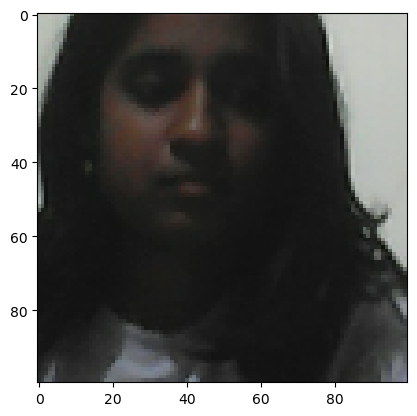

In [10]:
img = preprocess(pw_bytes)
plt.imshow(img)

Create labelled dataset

In [11]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

#Combine the positive and negative Datasets into one
data= positives.concatenate(negatives)

In [12]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
samples= data.as_numpy_iterator()

In [20]:
ex= samples.next()
ex   #iterate till u get anchor and negative in path

(b'D:\\data\\anchor\\27f8a77e-2c02-11ef-b9f8-cfd74ba3208b.jpg',
 b'D:\\data\\negative\\Hamid_Karzai_0006.jpg',
 0.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [22]:
res= preprocess_twin(*ex)

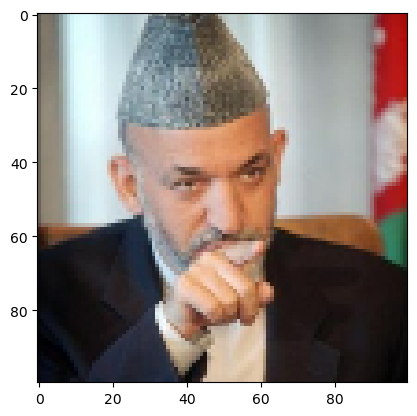

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

0.0

In [25]:
#build dataloader pipeline 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
#Training Part 
#70% of the data is taken first 
train_data = data.take(round(len(data)*0.7))

#now the data 
train_data = train_data.batch(16)
#starts preprocessing the next set of images so that we dont bottleup our neural networks
train_data=train_data.prefetch(8)

In [27]:
#Refine/Testing phase
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [29]:
inp = Input(shape=(100,100,3), name = "input_img")

In [30]:
cl1= Conv2D(64, (10,10), activation ='relu')(inp)

In [31]:
cl1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [32]:
m1= MaxPooling2D(64, (2,2), padding= 'same')(cl1)

In [33]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [34]:
cl2= Conv2D(128, (7,7), activation= 'relu')(m1)
m2= MaxPooling2D(64, (2,2), padding= 'same')(cl2)

print(cl2)
print(m2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv2d_1/Relu:0', description="created by layer 'conv2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [35]:
cl3= Conv2D(128, (4,4), activation='relu')(m2)
m3= MaxPooling2D(64,(2,2), padding= 'same')(cl3)

print(cl3)
print(m3)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 128), dtype=tf.float32, name=None), name='conv2d_2/Relu:0', description="created by layer 'conv2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")


In [36]:
cl4 = Conv2D(256, (4,4), activation='relu')(m3)

#flatting all the output of CNN Layer which are in 3D into a single dimension
f1 = Flatten()(cl4)
d1 = Dense(4096, activation= 'sigmoid')(f1)

print(cl4)
print(f1)
print(d1)


KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_3/Relu:0', description="created by layer 'conv2d_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [37]:
mod = Model(inputs=[inp], outputs=[d1], name="CNN Embeddings")

In [38]:
mod.summary()

Model: "CNN Embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)    

In [39]:
def make_embedding():

    #First Layer
    inp = Input(shape=(100,100,3), name ="input_img")
    cl1= Conv2D(64, (10,10), activation ='relu')(inp)
    m1= MaxPooling2D(64, (2,2), padding= 'same')(cl1)   

    #Second Layer
    cl2= Conv2D(128, (7,7), activation= 'relu')(m1)
    m2= MaxPooling2D(64, (2,2), padding= 'same')(cl2)  

    #Third Layer
    cl3= Conv2D(128, (4,4), activation='relu')(m2)
    m3= MaxPooling2D(64,(2,2), padding= 'same')(cl3)
    
    #Fourth Layer
    cl4 = Conv2D(256, (4,4), activation='relu')(m3)

    #flattning all the output of CNN Layer which are in 30 into a single Dimension
    f1 = Flatten()(cl4)
    d1 = Dense(4096, activation= 'sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name="Embeddings")

In [40]:
em= make_embedding()
em.summary()

Model: "Embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       2

Building Distance Layer 

In [41]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
#subtracting cause we want to determine the similarity between them

In [42]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image =  Input(name = ' validation_img', shape=(100,100,3))

In [43]:
em(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'Embeddings')>

In [44]:
inp_embedding = em(input_image)
val_embedding = em(validation_image)

In [45]:
siamese_layer = L1Dist()

In [46]:
distances = siamese_layer(inp_embedding, val_embedding)

In [47]:
classifier = Dense(1, activation='sigmoid')(distances)

In [48]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier,name='SaimeseNetwork')
siamese_network.summary() 

Model: "SaimeseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
  validation_img (InputLayer)   [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embeddings (Functional)        (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  ' validation_img[0]

In [49]:
def make_siamese_model():

    #Anchor image as input
    input_image = Input(name='input_img', shape=(100,100,3))

    #Validation image - Positive/Negative
    validation_image =  Input(name = ' validation_img', shape=(100,100,3))

    #combining all components 
    siamese_layer = L1Dist()
    siamese_layer._name ='distance'
    distances = siamese_layer(em(input_image), em(validation_image))

    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SaimeseNetwork')


In [50]:
siamese_model = make_siamese_model()

Training of Model

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4)

In [53]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model )


In [54]:

test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [55]:
batch_1

(array([[[[0.7264706 , 0.74607843, 0.722549  ],
          [0.722549  , 0.74215686, 0.7147059 ],
          [0.71887255, 0.7473039 , 0.7080882 ],
          ...,
          [0.7617647 , 0.7656863 , 0.74607843],
          [0.76862746, 0.77254903, 0.75      ],
          [0.7637255 , 0.7676471 , 0.7441176 ]],
 
         [[0.7245098 , 0.74509805, 0.7147059 ],
          [0.7198529 , 0.74313724, 0.70955884],
          [0.7169118 , 0.74828434, 0.7051471 ],
          ...,
          [0.76642156, 0.7703431 , 0.7468137 ],
          [0.7678922 , 0.77181375, 0.7490196 ],
          [0.7647059 , 0.76862746, 0.74607843]],
 
         [[0.72156864, 0.74509805, 0.7058824 ],
          [0.71838236, 0.74828434, 0.7058824 ],
          [0.7147059 , 0.74607843, 0.7029412 ],
          ...,
          [0.76862746, 0.77254903, 0.7490196 ],
          [0.7647059 , 0.76862746, 0.7480392 ],
          [0.7610294 , 0.764951  , 0.74534315]],
 
         ...,
 
         [[0.13799019, 0.13799019, 0.13014705],
          [0.15637

In [56]:
X = batch_1[:2]

In [57]:
Y = batch_1[2]

Build Train Functions

In [58]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss 


Building a trainable Loop

In [59]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [60]:
EPOCHS = 50

In [61]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 43s 43s/step

 Epoch 2/50
1/1 [==============================] - 0s 40ms/step

 Epoch 3/50
1/1 [==============================] - 1s 958ms/step

 Epoch 4/50
1/1 [==============================] - 1s 953ms/step

 Epoch 5/50
1/1 [==============================] - 3s 3s/step

 Epoch 6/50
1/1 [==============================] - 5s 5s/step

 Epoch 7/50
1/1 [==============================] - 3s 3s/step

 Epoch 8/50
1/1 [==============================] - 1s 914ms/step

 Epoch 9/50
1/1 [==============================] - 1s 900ms/step

 Epoch 10/50
1/1 [==============================] - 1s 876ms/step

 Epoch 11/50
1/1 [==============================] - 0s 39ms/step

 Epoch 12/50
1/1 [==============================] - 1s 1s/step

 Epoch 13/50
1/1 [==============================] - 1s 854ms/step

#Evaluate Model and Make Prediction

In [81]:
from tensorflow.keras.metrics import Precision, Recall

In [83]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [84]:
len(test_val)

4

In [85]:
y_true

array([0., 1., 1., 1.], dtype=float32)

In [86]:
test_var=test_data.as_numpy_iterator().next()

In [87]:
len(test_var)

3

In [88]:
test_var[2]

array([1., 1., 0., 0.], dtype=float32)

In [89]:
#Make predictions
y_hat=siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 35ms/step


array([[0.001769 ],
       [0.999928 ],
       [0.9979486],
       [0.9997451]], dtype=float32)

In [90]:
res=[]
for prediction in y_hat:
    if prediction>0.5:
        res.append(1)
    else:
        res.append(0)
res

[0, 1, 1, 1]

In [91]:
y_true

array([0., 1., 1., 1.], dtype=float32)

Calculating Metrics

In [92]:
#Create a metric object
m=Recall()

#Calculating the recall value
m.update_state(test_var[2],y_hat)

#Return the Recall Result
m.result().numpy()

0.5

In [93]:
#Create a metric object
m=Precision()

#Calculating the value
m.update_state(test_var[2],y_hat)

#Return the Recall Result
m.result().numpy()

0.33333334

In [ ]:
Visualise

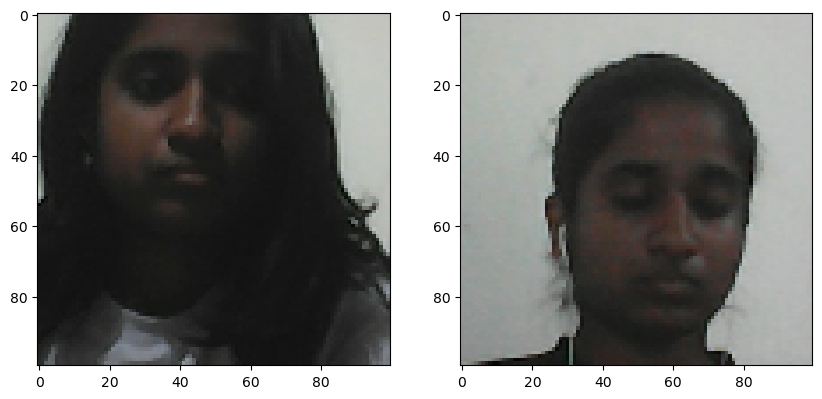

In [96]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[1])

plt.subplot(1,2,2)
plt.imshow(test_val[1])

plt.show()

Save the Model 

In [97]:
siamese_model.save('siamesemodel.h5')

In [98]:
#Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [99]:
#make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[0.001769 ],
       [0.999928 ],
       [0.9979486],
       [0.9997451]], dtype=float32)

In [100]:
model.summary()

Model: "SaimeseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
  validation_img (InputLayer)   [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embeddings (Functional)        (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  ' validation_img[0]

Real Time Verification 

In [101]:
import os
path = "application_data/verification_images"
path1 = "application_data/input_image"
isExist = os.path.exists(path)
isExist = os.path.exists(path1)
if not isExist:
    os.makedirs(path)
if not isExist:
    os.makedirs(path1)

In [102]:
os.listdir(os.path.join('application_data', 'verification_images'))

['b1e57f59-2c77-11ef-8286-cfd74ba3208b - Copy.jpg',
 'b1e57f59-2c77-11ef-8286-cfd74ba3208b.jpg',
 'b4ec6b66-2c77-11ef-91ac-cfd74ba3208b - Copy.jpg',
 'b4ec6b66-2c77-11ef-91ac-cfd74ba3208b.jpg',
 'b7ed1430-2c77-11ef-bf1b-cfd74ba3208b - Copy.jpg',
 'b7ed1430-2c77-11ef-bf1b-cfd74ba3208b.jpg']

In [103]:
os.path.join('application_data', 'input_image', 'input_image.jpg')   

'application_data\\input_image\\input_image.jpg'

add delete function 

In [104]:
#captured image from webcam will be stored in this folder
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [105]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\b1e57f59-2c77-11ef-8286-cfd74ba3208b - Copy.jpg
application_data\verification_images\b1e57f59-2c77-11ef-8286-cfd74ba3208b.jpg
application_data\verification_images\b4ec6b66-2c77-11ef-91ac-cfd74ba3208b - Copy.jpg
application_data\verification_images\b4ec6b66-2c77-11ef-91ac-cfd74ba3208b.jpg
application_data\verification_images\b7ed1430-2c77-11ef-bf1b-cfd74ba3208b - Copy.jpg
application_data\verification_images\b7ed1430-2c77-11ef-bf1b-cfd74ba3208b.jpg


In [107]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [110]:
#webcam verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
        
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    
    k = cv2.waitKey(30) & 0xff
    if k == 113: 
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 27ms/step
True
1/1 [==============================] - 0s 32ms/step
True


KeyboardInterrupt: 